In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import random
import tensorflow as tf
from sklearn.metrics import classification_report,f1_score,confusion_matrix
import os, shutil
from glob import glob
from tqdm import tqdm
import cv2
from colorama import Fore, Back, Style
sns.set(style='dark')
from tensorflow.keras import layers, models, Model, optimizers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Concatenate,Input,Average
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers,callbacks
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import Xception
from sklearn.model_selection import KFold



# Helper Functions

In [2]:
# A nice function to help me visualize and explore the data images
def show_grid(files, row=3, col=3):
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.resize(cv2.imread(image_path), dsize=(512,512))
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [3]:
# Function that helps in image plotting
def show_img(path):
    img = cv2.imread(path,0)
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='bone')

In [4]:
#helper function to wrap the generator and make it easy to modify it
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,batch_y)

# Exploratory data Analysis

In [5]:
#reading our dataset
data = pd.read_csv('/kaggle/input/clothing-dataset-full/images.csv')
data.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [6]:
#Adding the image file path to our dataframe
data['image_path']='/kaggle/input/clothing-dataset-full/images_compressed/'+data['image']+'.jpg'
data.head()

,image,sender_id,label,kids,image_path
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False,/kaggle/input/clothing-dataset-full/images_com...
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False,/kaggle/input/clothing-dataset-full/images_com...
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False,/kaggle/input/clothing-dataset-full/images_com...
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False,/kaggle/input/clothing-dataset-full/images_com...
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False,/kaggle/input/clothing-dataset-full/images_com...


In [7]:
data.shape

(5403, 5)

In [8]:
data.duplicated().sum()

0

In [9]:
data.isnull().sum()

image         0
sender_id     0
label         0
kids          0
image_path    0
dtype: int64

### When I tried to train the model at the first time there were some corrupted images so I had to get back and remove those images from the dataset using the following code

In [10]:
import PIL
from pathlib import Path
import glob
from PIL import UnidentifiedImageError
corrupted_images = []
path = glob.glob('/kaggle/input/clothing-dataset-full/images_compressed/*.jpg')
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            corrupted_images.append(img_p)
corrupted_images

['/kaggle/input/clothing-dataset-full/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
 '/kaggle/input/clothing-dataset-full/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
 '/kaggle/input/clothing-dataset-full/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
 '/kaggle/input/clothing-dataset-full/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
 '/kaggle/input/clothing-dataset-full/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg',
 '/kaggle/input/clothing-dataset-full/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

In [11]:
data = data[~data.image_path.isin(corrupted_images)]
data.shape

(5398, 5)

# Sample of the dataset

100%|██████████| 18/18 [00:00<00:00, 146.36it/s]


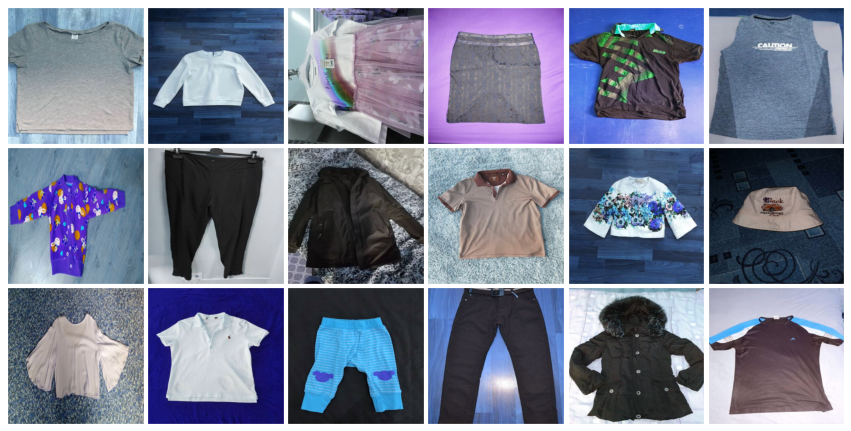

In [12]:
show_grid(data.image_path.tolist(), row=6)

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip             7
Name: label, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


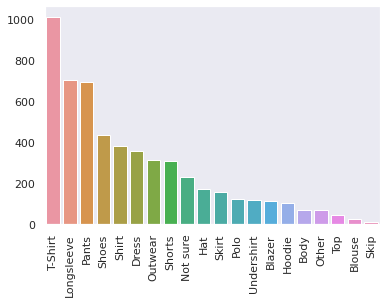

In [13]:
#exploring the classes distribution in the dataset
print(data.label.value_counts())
hist = sns.barplot(data.label.value_counts().index,data.label.value_counts().tolist())
hist.tick_params(axis='x', rotation=90)

### It seems that data has a huge class imbalance in it and some classes barely exist in the data so augmentation may not help in this situation, but lets see how we can handle this issue

# Data Loading and preparation

In [14]:
data = data[['image_path','label']]

In [15]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# data.label =le.fit_transform(data.label)

In [16]:
#splitting the dataset into 2 parts for training and testing 
trainX,testX,trainY,testY = train_test_split(data,data.label,
                                             test_size=0.2,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=data.label,
                                            )

In [17]:
# from sklearn.utils import compute_class_weight

# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(trainY),
#                                         y = trainY                                                    
#                                     )
# class_weights = dict(zip(np.unique(trainY), class_weights))
# class_weights

In [18]:
#encoding the labels
trainY = pd.get_dummies(trainY)
testY = pd.get_dummies(testY)

In [19]:
#Stack the images and the labels together 
trainX = pd.concat((trainX,trainY),axis=1)
testX = pd.concat((testX,testY),axis=1)
trainX.head()

,image_path,label,Blazer,Blouse,Body,Dress,Hat,Hoodie,Longsleeve,Not sure,...,Pants,Polo,Shirt,Shoes,Shorts,Skip,Skirt,T-Shirt,Top,Undershirt
881,/kaggle/input/clothing-dataset-full/images_com...,Shorts,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3029,/kaggle/input/clothing-dataset-full/images_com...,Shirt,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4418,/kaggle/input/clothing-dataset-full/images_com...,Outwear,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
788,/kaggle/input/clothing-dataset-full/images_com...,Shoes,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2789,/kaggle/input/clothing-dataset-full/images_com...,T-Shirt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# Data generators and augmentations
datagen=ImageDataGenerator(
    rescale=1./255)

test_datagen=ImageDataGenerator(
    rescale=1./255.,)

In [21]:
num_classes = data.label.nunique()

# Model Building and training

In [22]:
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
VGG.trainable=False
dense = VGG.output
dense = Flatten()(dense) 
dropout = Dropout(.3)(dense)
output = Dense(num_classes,activation='softmax')(dropout)
model1 = Model(VGG.input, outputs=[output])

2023-01-23 21:13:26.282008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 21:13:26.283287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 21:13:26.418487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 21:13:26.419772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 21:13:26.420914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


# First approach

In [23]:
model1.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
callback = [
    callbacks.ModelCheckpoint(
        "VGG.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

In [24]:
trainX['image_path']=trainX['image_path'].astype('str')
testX['image_path']=testX['image_path'].astype('str')

Found 4318 validated image filenames.
Found 1080 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-23 21:13:35.523291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-23 21:13:37.507514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


67/67 [==============================] - 53s 526ms/step - loss: 2.2016 - accuracy: 0.3790 - val_loss: 1.5471 - val_accuracy: 0.5967
Epoch 2/15
67/67 [==============================] - 40s 526ms/step - loss: 1.4195 - accuracy: 0.6079 - val_loss: 1.2357 - val_accuracy: 0.6689
Epoch 3/15
67/67 [==============================] - 36s 534ms/step - loss: 1.1334 - accuracy: 0.6787 - val_loss: 1.0939 - val_accuracy: 0.6963
Epoch 4/15
67/67 [==============================] - 36s 541ms/step - loss: 0.9541 - accuracy: 0.7264 - val_loss: 1.0046 - val_accuracy: 0.7197
Epoch 5/15
67/67 [==============================] - 35s 531ms/step - loss: 0.8134 - accuracy: 0.7781 - val_loss: 0.9571 - val_accuracy: 0.7227
Epoch 6/15
67/67 [==============================] - 35s 526ms/step - loss: 0.7228 - accuracy: 0.8011 - val_loss: 0.9004 - val_accuracy: 0.7314
Epoch 7/15
67/67 [==============================] - 35s 520ms/step - loss: 0.6599 - accuracy: 0.8188 - val_loss: 0.8907 - val_accuracy: 0.7412
Epoch 8/15

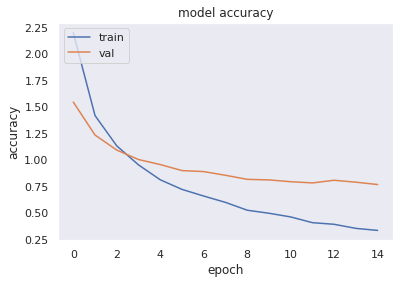

In [25]:
columns = trainX.columns[2:]
train_generator=datagen.flow_from_dataframe(dataframe=trainX,x_col="image_path",
                                        y_col=columns,batch_size=64,seed=42,shuffle=True,class_mode="raw",target_size=(224,224))

valid_generator=test_datagen.flow_from_dataframe(dataframe=testX,x_col="image_path",
                                        y_col=columns,batch_size=64,seed=42,shuffle=True,class_mode="raw",target_size=(224,224))
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = model1.fit_generator(generator=generator_wrapper(train_generator),steps_per_epoch=STEP_SIZE_TRAIN
                            ,validation_data=generator_wrapper(valid_generator),validation_steps=STEP_SIZE_VALID,
                                   epochs=15,verbose=1,callbacks=[callback])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Found 1080 validated image filenames.
Model Evaluation using Keras...

17/17 [==============================] - 16s 972ms/step - loss: 0.7740 - accuracy: 0.7667
[0.7739914059638977, 0.7666666507720947] 

Running Model Inference...

17/17 [==============================] - 6s 361ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report
               precision    recall  f1-score   support

           0       0.67      0.45      0.54        22
           1       0.00      0.00      0.00         5
           2       0.88      0.50      0.64        14
           3       0.71      0.76      0.73        71
           4       0.94      0.91      0.93        34
           5       0.73      0.40      0.52        20
           6       0.74      0.86      0.79       140
           7       0.32      0.13      0.18        46
           8       0.14      0.08      0.10        13
           9       0.62      0.73      0.67        62
          10       0.90      0.93      0.92       138
          11       0.60      0.25      0.35        24
          12       0.72      0.71      0.72        76
          13       1.00      0.99      0.99        86
          14       0.76      0.82      0.79        62
          15       0.00      0.00      0.00         1
          16       0.82      0.58      0.68        31
    

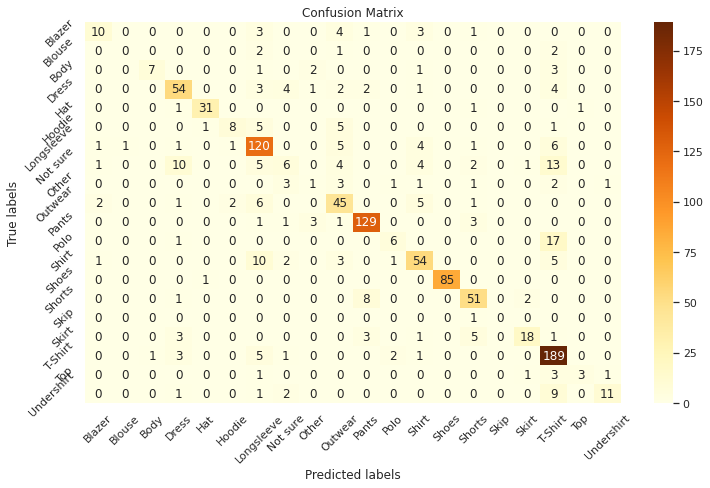

In [26]:
test_generator=test_datagen.flow_from_dataframe(dataframe=testX,x_col="image_path",
                                        y_col=columns,batch_size=64,seed=42,shuffle=False,class_mode="raw",target_size=(224,224))
print('Model Evaluation using Keras...\n')
print(model1.evaluate(test_generator),"\n")
test_generator.reset()
print('Running Model Inference...\n')
preds=model1.predict(test_generator,verbose=1)
Y = tf.one_hot(tf.argmax(preds.T),depth=20)
print("Classification Report\n",classification_report(testY,Y))
print(f1_score(testY,Y,average='weighted'))
classes = trainY.columns
fig, ax = plt.subplots(figsize=(12,7))

cm = confusion_matrix(tf.argmax(testY.values,axis=1), tf.argmax(Y,axis=1))
# labels, title and ticks
ax.set_title('Confusion Matrix'); 
sns.heatmap(cm, annot=True,fmt='g',cmap='YlOrBr',ax=ax)
ax.yaxis.set_ticklabels(classes,rotation=45); ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(classes,rotation=45);ax.set_xlabel('Predicted labels');

> ### We notice that there is a huge overfitting in the model and this might be because of the class imbalance, I tried different model architectures, different learning rates and dropout rates but Non of them helped 

# Second approach

In [27]:
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
VGG.trainable=False
dense = VGG.output
dense = Flatten()(dense) 
dropout = Dropout(.3)(dense)
output = Dense(num_classes,activation='softmax')(dropout)
model2 = Model(VGG.input, outputs=[output])


In [28]:
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
callback = [
    callbacks.ModelCheckpoint(
        "VGG.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

Found 3238 validated image filenames.
Found 1080 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 30s 588ms/step - loss: 2.2508 - accuracy: 0.3597 - val_loss: 1.7286 - val_accuracy: 0.5303
Epoch 2/10
50/50 [==============================] - 35s 582ms/step - loss: 1.5363 - accuracy: 0.5605 - val_loss: 1.4238 - val_accuracy: 0.6230
Epoch 3/10
50/50 [==============================] - 27s 544ms/step - loss: 1.2321 - accuracy: 0.6440 - val_loss: 1.2496 - val_accuracy: 0.6719
Epoch 4/10
50/50 [==============================] - 27s 545ms/step - loss: 1.0267 - accuracy: 0.7057 - val_loss: 1.1782 - val_accuracy: 0.6826
Epoch 5/10
50/50 [==============================] - 27s 555ms/step - loss: 0.8955 - accuracy: 0.7432 - val_loss: 1.1008 - val_accuracy: 0.6934
Epoch 6/10
50/50 [==============================] - 27s 555ms/step - loss: 0.7754 - accuracy: 0.7826 - val_loss: 1.0687 - val_accuracy: 0.7041
Epoch 7/10
50/50 [==============================] - 28s 571ms/step - loss: 0.7007 - accuracy: 0.8094 - val_loss: 1.0471 - val_accuracy: 0.7002

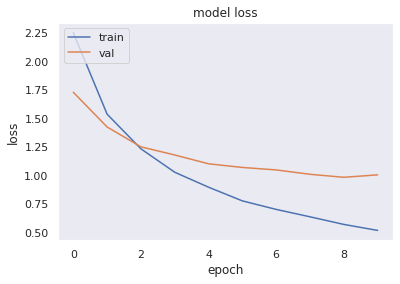

Found 3238 validated image filenames.
Found 1080 validated image filenames.
Epoch 1/10
50/50 [==============================] - 28s 558ms/step - loss: 0.6680 - accuracy: 0.8228 - val_loss: 0.4213 - val_accuracy: 0.9092
Epoch 2/10
50/50 [==============================] - 27s 545ms/step - loss: 0.6074 - accuracy: 0.8447 - val_loss: 0.4140 - val_accuracy: 0.9170
Epoch 3/10
50/50 [==============================] - 27s 545ms/step - loss: 0.5448 - accuracy: 0.8620 - val_loss: 0.4187 - val_accuracy: 0.8984
Epoch 4/10
50/50 [==============================] - 27s 544ms/step - loss: 0.5111 - accuracy: 0.8686 - val_loss: 0.4015 - val_accuracy: 0.9121
Epoch 5/10
50/50 [==============================] - 26s 535ms/step - loss: 0.4704 - accuracy: 0.8859 - val_loss: 0.4114 - val_accuracy: 0.9043
Epoch 6/10
50/50 [==============================] - 27s 553ms/step - loss: 0.4150 - accuracy: 0.9011 - val_loss: 0.4073 - val_accuracy: 0.8994
Epoch 7/10
50/50 [==============================] - 27s 538ms/step

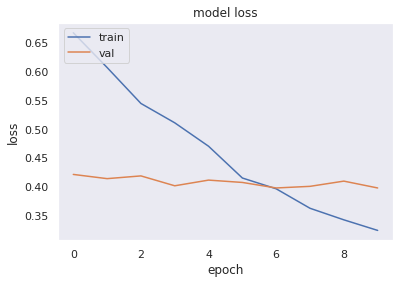

Found 3239 validated image filenames.
Found 1079 validated image filenames.
Epoch 1/10
50/50 [==============================] - 27s 548ms/step - loss: 0.3656 - accuracy: 0.9100 - val_loss: 0.2164 - val_accuracy: 0.9727
Epoch 2/10
50/50 [==============================] - 33s 533ms/step - loss: 0.3392 - accuracy: 0.9228 - val_loss: 0.2235 - val_accuracy: 0.9678
Epoch 3/10
50/50 [==============================] - 26s 532ms/step - loss: 0.3034 - accuracy: 0.9417 - val_loss: 0.2225 - val_accuracy: 0.9658
Epoch 4/10
50/50 [==============================] - 26s 529ms/step - loss: 0.2914 - accuracy: 0.9468 - val_loss: 0.2237 - val_accuracy: 0.9648
Epoch 5/10
50/50 [==============================] - 26s 531ms/step - loss: 0.2751 - accuracy: 0.9496 - val_loss: 0.2276 - val_accuracy: 0.9629
Epoch 6/10
50/50 [==============================] - 28s 569ms/step - loss: 0.2502 - accuracy: 0.9587 - val_loss: 0.2313 - val_accuracy: 0.9609
Epoch 7/10
50/50 [==============================] - 28s 563ms/step

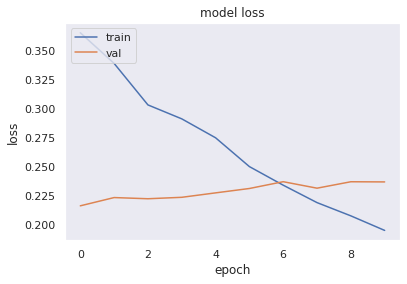

Found 3239 validated image filenames.
Found 1079 validated image filenames.
Epoch 1/10
50/50 [==============================] - 29s 585ms/step - loss: 0.2272 - accuracy: 0.9572 - val_loss: 0.1356 - val_accuracy: 0.9912
Epoch 2/10
50/50 [==============================] - 28s 577ms/step - loss: 0.2096 - accuracy: 0.9669 - val_loss: 0.1386 - val_accuracy: 0.9912
Epoch 3/10
50/50 [==============================] - 29s 577ms/step - loss: 0.1909 - accuracy: 0.9735 - val_loss: 0.1395 - val_accuracy: 0.9922
Epoch 4/10
50/50 [==============================] - 67s 1s/step - loss: 0.1807 - accuracy: 0.9729 - val_loss: 0.1419 - val_accuracy: 0.9883
Epoch 5/10
50/50 [==============================] - 48s 980ms/step - loss: 0.1716 - accuracy: 0.9786 - val_loss: 0.1450 - val_accuracy: 0.9863
Epoch 6/10
50/50 [==============================] - 29s 577ms/step - loss: 0.1612 - accuracy: 0.9839 - val_loss: 0.1466 - val_accuracy: 0.9893
Epoch 7/10
50/50 [==============================] - 28s 573ms/step - 

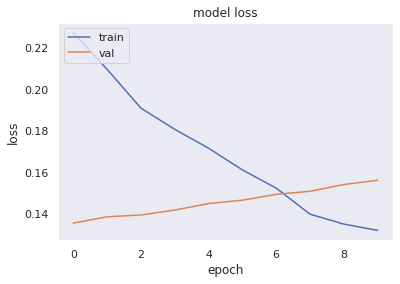

In [29]:
columns = trainY.columns
kf = KFold(n_splits=4, random_state=42, shuffle=True)
X= np.array(trainX["image_path"])
for train_index, valid_index in kf.split(X):
    trainData = X[train_index]
    validData = X[valid_index]
    train_df = trainX.loc[trainX["image_path"].isin(list(trainData))]
    valid_df = trainX.loc[trainX["image_path"].isin(list(validData))]


    train_generator=datagen.flow_from_dataframe(dataframe=train_df,x_col="image_path",
                                            y_col=columns,batch_size=64,seed=42,shuffle=True,class_mode="raw",target_size=(224,224))

    valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df,x_col="image_path",
                                            y_col=columns,batch_size=64,seed=42,shuffle=True,class_mode="raw",target_size=(224,224))
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    
    
    history = model2.fit_generator(generator=generator_wrapper(train_generator),steps_per_epoch=STEP_SIZE_TRAIN
                            ,validation_data=generator_wrapper(valid_generator),validation_steps=STEP_SIZE_VALID,
                                   epochs=10,verbose=1,callbacks=[callback])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Found 1080 validated image filenames.
Model Evaluation using Keras...

17/17 [==============================] - 7s 422ms/step - loss: 0.7740 - accuracy: 0.7667
[0.7739914059638977, 0.7666666507720947] 

Running Model Inference...

17/17 [==============================] - 6s 348ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report
               precision    recall  f1-score   support

           0       0.67      0.45      0.54        22
           1       0.00      0.00      0.00         5
           2       0.88      0.50      0.64        14
           3       0.71      0.76      0.73        71
           4       0.94      0.91      0.93        34
           5       0.73      0.40      0.52        20
           6       0.74      0.86      0.79       140
           7       0.32      0.13      0.18        46
           8       0.14      0.08      0.10        13
           9       0.62      0.73      0.67        62
          10       0.90      0.93      0.92       138
          11       0.60      0.25      0.35        24
          12       0.72      0.71      0.72        76
          13       1.00      0.99      0.99        86
          14       0.76      0.82      0.79        62
          15       0.00      0.00      0.00         1
          16       0.82      0.58      0.68        31
    

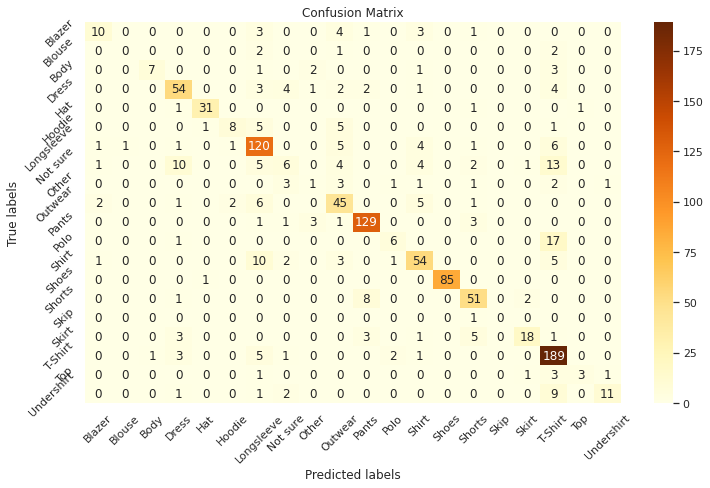

In [30]:
test_generator=test_datagen.flow_from_dataframe(dataframe=testX,x_col="image_path",
                                        y_col=columns,batch_size=64,seed=42,shuffle=False,class_mode="raw",target_size=(224,224))
test_generator.reset()
print('Model Evaluation using Keras...\n')
print(model1.evaluate(test_generator),"\n")
print('Running Model Inference...\n')
preds=model1.predict(test_generator,verbose=1)
Y = tf.one_hot(tf.argmax(preds.T),depth=20)
print("Classification Report\n",classification_report(testY,Y))
print(f1_score(testY,Y,average='weighted'))
classes = trainY.columns
fig, ax = plt.subplots(figsize=(12,7))

cm = confusion_matrix(tf.argmax(testY.values,axis=1), tf.argmax(Y,axis=1))
# labels, title and ticks
ax.set_title('Confusion Matrix'); 
sns.heatmap(cm, annot=True,fmt='g',cmap='YlOrBr',ax=ax)
ax.yaxis.set_ticklabels(classes,rotation=45); ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(classes,rotation=45);ax.set_xlabel('Predicted labels');

> #### It seems that the cross validation didn't help alot in learning all the classes and make the model generalize well.

### Let's remove the calsses that adds noise to the dataset

In [31]:
data.shape

(5398, 2)

In [45]:
topk = data.label.value_counts().index[:12]
topk

Index(['T-Shirt', 'Longsleeve', 'Pants', 'Shoes', 'Shirt', 'Dress', 'Outwear',
       'Shorts', 'Not sure', 'Hat', 'Skirt', 'Polo'],
      dtype='object')

In [55]:
data = data[data.label.isin(topk)]

In [56]:
#splitting the dataset into 2 parts for training and testing 
trainX,testX,trainY,testY = train_test_split(data,data.label,
                                             test_size=0.2,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=data.label,
                                            )

In [57]:
#encoding the labels
trainY = pd.get_dummies(trainY)
testY = pd.get_dummies(testY)
#Stack the images and the labels together 
trainX = pd.concat((trainX,trainY),axis=1)
testX = pd.concat((testX,testY),axis=1)


In [59]:
testY.shape

(973, 12)

In [64]:
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
VGG.trainable=False
dense = VGG.output
dense = Flatten()(dense) 
dropout = Dropout(.3)(dense)
output = Dense(len(topk),activation='softmax')(dropout)
model3 = Model(VGG.input, outputs=[output])

In [65]:
model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
callback = [
    callbacks.ModelCheckpoint(
        "VGG.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

Found 2592 validated image filenames.
Found 1297 validated image filenames.
Epoch 1/10
40/40 [==============================] - 27s 673ms/step - loss: 2.0516 - accuracy: 0.3578 - val_loss: 1.5669 - val_accuracy: 0.5305
Epoch 2/10
40/40 [==============================] - 33s 675ms/step - loss: 1.3811 - accuracy: 0.5815 - val_loss: 1.2120 - val_accuracy: 0.6609
Epoch 3/10
40/40 [==============================] - 26s 668ms/step - loss: 1.0911 - accuracy: 0.6752 - val_loss: 1.0356 - val_accuracy: 0.7031
Epoch 4/10
40/40 [==============================] - 27s 685ms/step - loss: 0.9107 - accuracy: 0.7298 - val_loss: 0.9616 - val_accuracy: 0.7070
Epoch 5/10
40/40 [==============================] - 27s 688ms/step - loss: 0.7954 - accuracy: 0.7749 - val_loss: 0.8847 - val_accuracy: 0.7305
Epoch 6/10
40/40 [==============================] - 27s 682ms/step - loss: 0.6949 - accuracy: 0.8097 - val_loss: 0.8278 - val_accuracy: 0.7539
Epoch 7/10
40/40 [==============================] - 27s 689ms/step

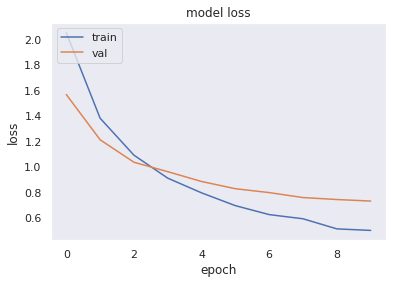

Found 2593 validated image filenames.
Found 1296 validated image filenames.
Epoch 1/10
40/40 [==============================] - 28s 698ms/step - loss: 0.6117 - accuracy: 0.8277 - val_loss: 0.4075 - val_accuracy: 0.9219
Epoch 2/10
40/40 [==============================] - 34s 706ms/step - loss: 0.5486 - accuracy: 0.8490 - val_loss: 0.3998 - val_accuracy: 0.9117
Epoch 3/10
40/40 [==============================] - 27s 681ms/step - loss: 0.5019 - accuracy: 0.8612 - val_loss: 0.3931 - val_accuracy: 0.9102
Epoch 4/10
40/40 [==============================] - 26s 657ms/step - loss: 0.4685 - accuracy: 0.8778 - val_loss: 0.3844 - val_accuracy: 0.9102
Epoch 5/10
40/40 [==============================] - 26s 657ms/step - loss: 0.4125 - accuracy: 0.8921 - val_loss: 0.3913 - val_accuracy: 0.8977
Epoch 6/10
40/40 [==============================] - 26s 660ms/step - loss: 0.3880 - accuracy: 0.9023 - val_loss: 0.3903 - val_accuracy: 0.9109
Epoch 7/10
40/40 [==============================] - 25s 631ms/step

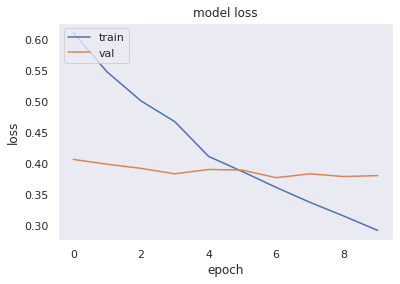

Found 2593 validated image filenames.
Found 1296 validated image filenames.
Epoch 1/10
40/40 [==============================] - 26s 646ms/step - loss: 0.3639 - accuracy: 0.9039 - val_loss: 0.2121 - val_accuracy: 0.9711
Epoch 2/10
40/40 [==============================] - 27s 684ms/step - loss: 0.3407 - accuracy: 0.9095 - val_loss: 0.2209 - val_accuracy: 0.9695
Epoch 3/10
40/40 [==============================] - 26s 667ms/step - loss: 0.3148 - accuracy: 0.9209 - val_loss: 0.2167 - val_accuracy: 0.9688
Epoch 4/10
40/40 [==============================] - 26s 669ms/step - loss: 0.2760 - accuracy: 0.9431 - val_loss: 0.2181 - val_accuracy: 0.9695
Epoch 5/10
40/40 [==============================] - 26s 661ms/step - loss: 0.2715 - accuracy: 0.9375 - val_loss: 0.2213 - val_accuracy: 0.9578
Epoch 6/10
40/40 [==============================] - 27s 690ms/step - loss: 0.2521 - accuracy: 0.9541 - val_loss: 0.2164 - val_accuracy: 0.9680
Epoch 7/10
40/40 [==============================] - 26s 654ms/step

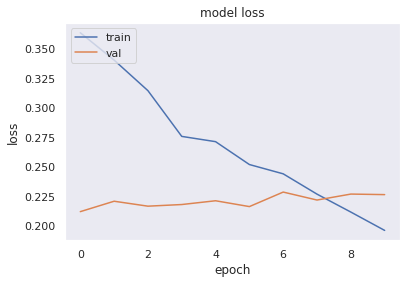

In [67]:
columns = trainY.columns
kf = KFold(n_splits=3, random_state=42, shuffle=True)
X= np.array(trainX["image_path"])
for train_index, valid_index in kf.split(X):
    trainData = X[train_index]
    validData = X[valid_index]
    train_df = trainX.loc[trainX["image_path"].isin(list(trainData))]
    valid_df = trainX.loc[trainX["image_path"].isin(list(validData))]


    train_generator=datagen.flow_from_dataframe(dataframe=train_df,x_col="image_path",
                                            y_col=columns,batch_size=64,seed=42,shuffle=True,class_mode="raw",target_size=(224,224))

    valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df,x_col="image_path",
                                            y_col=columns,batch_size=64,seed=42,shuffle=True,class_mode="raw",target_size=(224,224))
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    
    
    history = model3.fit_generator(generator=generator_wrapper(train_generator),steps_per_epoch=STEP_SIZE_TRAIN
                            ,validation_data=generator_wrapper(valid_generator),validation_steps=STEP_SIZE_VALID,
                                   epochs=10,verbose=1,callbacks=[callback])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Found 973 validated image filenames.
Model Evaluation using Keras...

16/16 [==============================] - 10s 596ms/step - loss: 0.5899 - accuracy: 0.7965
[0.5898639559745789, 0.7965056300163269] 

Running Model Inference...

16/16 [==============================] - 6s 355ms/step
Classification Report
               precision    recall  f1-score   support

           0       0.76      0.70      0.73        71
           1       0.97      0.82      0.89        34
           2       0.73      0.79      0.76       140
           3       0.26      0.15      0.19        46
           4       0.72      0.74      0.73        62
           5       0.85      0.96      0.91       139
           6       0.67      0.33      0.44        24
           7       0.77      0.76      0.77        76
           8       0.98      0.95      0.96        86
           9       0.84      0.77      0.81        62
          10       0.85      0.55      0.67        31
          11       0.81      0.93      0.8

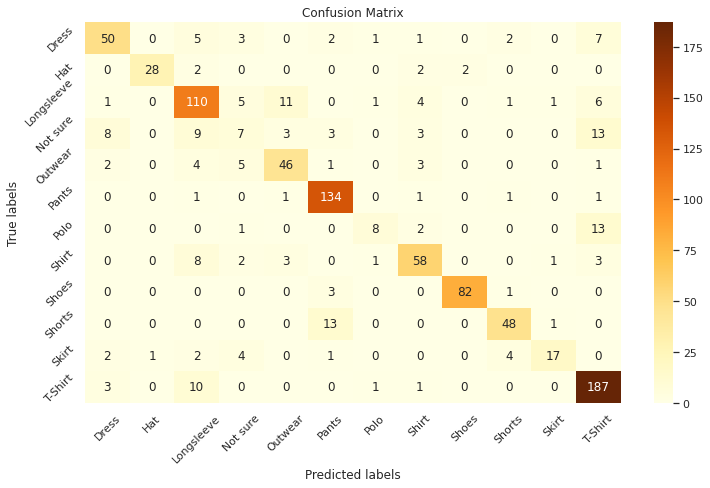

In [68]:
test_generator=test_datagen.flow_from_dataframe(dataframe=testX,x_col="image_path",
                                        y_col=columns,batch_size=64,seed=42,shuffle=False,class_mode="raw",target_size=(224,224))
test_generator.reset()
print('Model Evaluation using Keras...\n')
print(model3.evaluate(test_generator),"\n")
print('Running Model Inference...\n')
preds=model3.predict(test_generator,verbose=1)
Y = tf.one_hot(tf.argmax(preds.T),depth=12)
print("Classification Report\n",classification_report(testY,Y))
print(f1_score(testY,Y,average='weighted'))
classes = trainY.columns
fig, ax = plt.subplots(figsize=(12,7))

cm = confusion_matrix(tf.argmax(testY.values,axis=1), tf.argmax(Y,axis=1))
# labels, title and ticks
ax.set_title('Confusion Matrix'); 
sns.heatmap(cm, annot=True,fmt='g',cmap='YlOrBr',ax=ax)
ax.yaxis.set_ticklabels(classes,rotation=45); ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(classes,rotation=45);ax.set_xlabel('Predicted labels');

> ### Now we can say that the model genralizes better when the small classes are removed which makes since 

### Calclating Number of Flops and MACCS

In [69]:
!git clone https://github.com/ckyrkou/Keras_FLOP_Estimator.git

Cloning into 'Keras_FLOP_Estimator'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 176 (delta 3), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (176/176), 140.48 KiB | 2.75 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [70]:
cd /kaggle/working

/kaggle/working


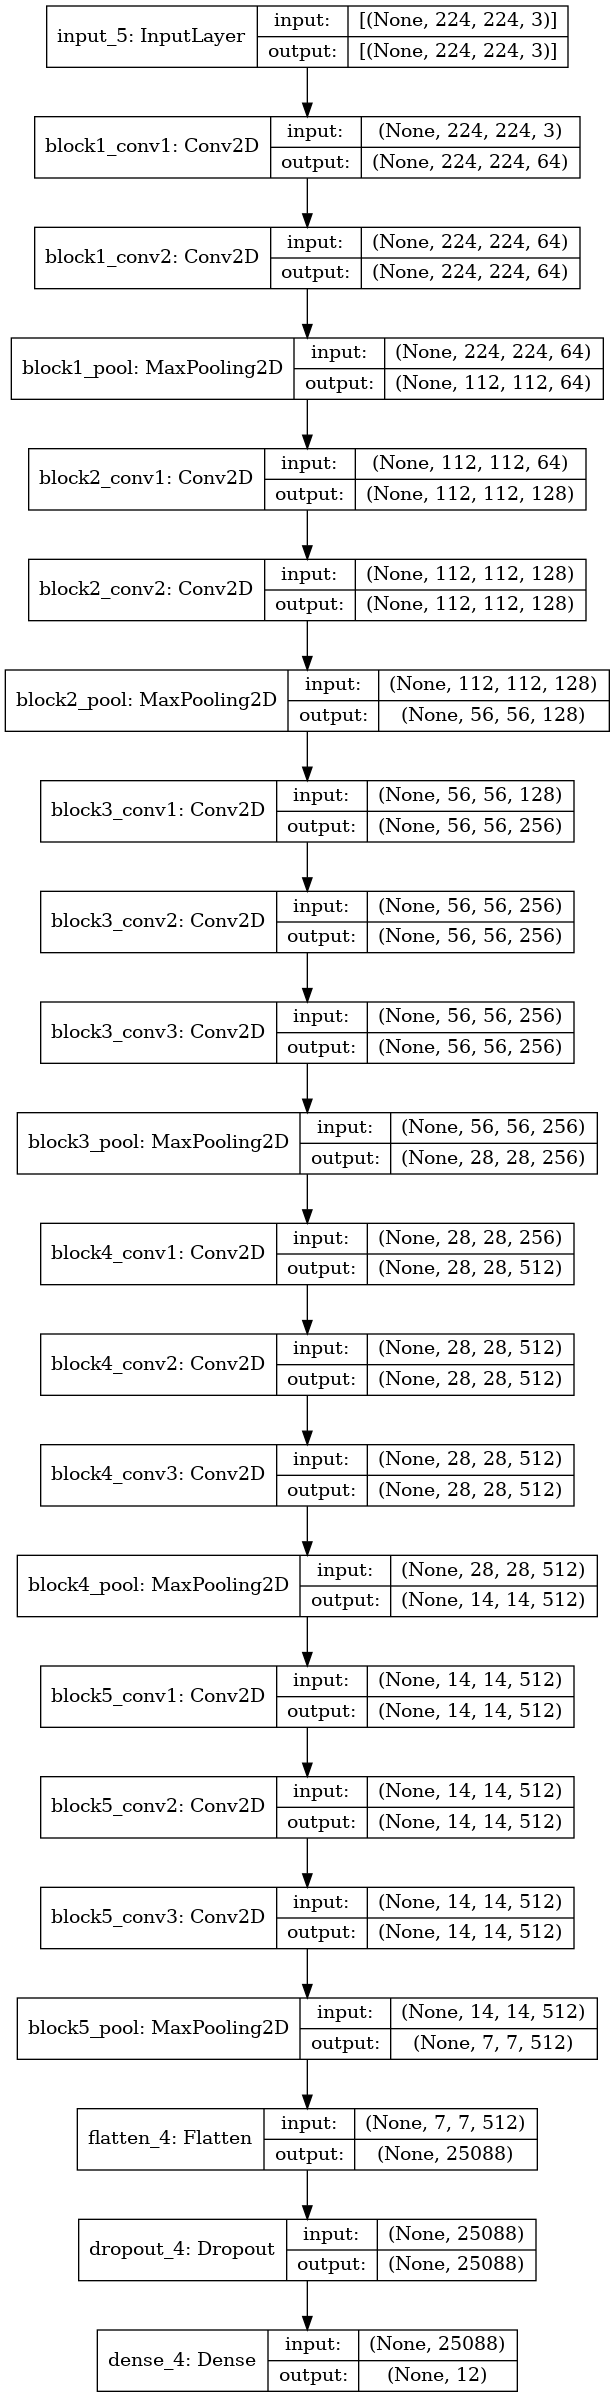

In [72]:
plot_model(model3, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True) 

In [75]:
from Keras_FLOP_Estimator.python_code.net_flops import net_flops
net_flops(model3,table=True)

               Layer Name |      Input Shape |     Output Shape |      Kernel Size |          Filters | Strides |  FLOPS
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  input_5 |    [224, 224, 3] |    [224, 224, 3] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
             block1_conv1 |    [224, 224, 3] |   [224, 224, 64] |           (3, 3) |               64 | (1, 1) | 173408256.0000
             block1_conv2 |   [224, 224, 64] |   [224, 224, 64] |           (3, 3) |               64 | (1, 1) | 3699376128.0000
              block1_pool |   [224, 224, 64] |     ['', '', ''] |           (2, 2) |           [0, 0] | (2, 2) | 3211264.0000
             block2_conv1 |   [112, 112, 64] |  [112, 112, 128] |           (3, 3) |              128 | (1, 1) | 1849688064.0000
             block2_conv2 |  [112, 112, 128] |  [112, 112, 128] |           

> ### The total number of flops is 30699.98489600
> ### The total number of MACCs is 15346931712
> ### The most expensive layer is block2_conv2 layer & block3_conv2

# How to Reduce That number 

We can reduce that number of flops by one or more of the following techniques:
1. Layer Pruning:  Layer Pruning aims to optimise the model by eliminating the **Layers** with small values or small contribution in the model output to gain computationally cost efficient model that takes less time in training or deployment
2. Node Pruning: Node Pruning aims to optimise the model by eliminating the **Nodes** with small values or small contribution in the model output to gain computationally cost efficient model that takes less time in training or deployment.It is similar to the dropout effect but on the computational scale
3. Remove some convoltuional Layers since they are the most computationally expensive in our case

In [76]:
import time
def time_per_layer(model):
    new_model = model
    times = np.zeros((len(model.layers), 2))
    inp = np.ones((224, 224, 3))
    for i in range(1, len(model.layers)):
        new_model = Model(inputs=[model.input], outputs=[model.layers[-i].output])

        # new_model.summary()
        new_model.predict(inp[None, :, :, :])

        t_s = time.time()
        new_model.predict(inp[None, :, :, :])
        t_e2 = time.time() - t_s

        times[i, 1] = t_e2
        del new_model

    for i in range(0, len(model.layers) - 1):
        times[i, 0] = abs(times[i + 1, 1] - times[i, 1])

    times[-1, 0] = times[-1, 1]


    return times

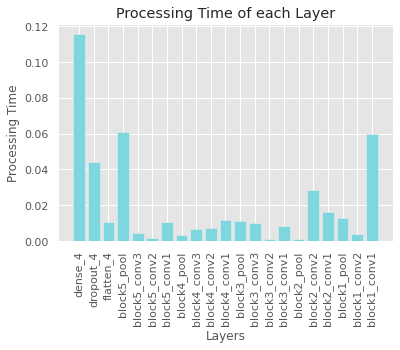

In [80]:
times = time_per_layer(model3)
plt.style.use('ggplot')
x = [model3.layers[-i].name for i in range(1,len(model3.layers))]
g = [times[i,0] for i in range(1,len(times))]
x_pos = np.arange(len(x))
plt.bar(x, g, color='#7ed6df')
plt.xlabel("Layers")
plt.ylabel("Processing Time")
plt.title("Processing Time of each Layer")
plt.xticks(x_pos, x,rotation=90)

plt.show()